In [1]:
import sys
sys.path.append('/eos/home-i00/l/lkoller/SWAN_projects/data analysis 2024/LyA/commands')
sys.path.append('/eos/home-i00/l/lkoller/data-analysis-software/')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
from Lfile import Lfile
from Ldate import Ldate
import math
from readTrc_4CH import Trc
from scipy.optimize import curve_fit
from tqdm import tqdm
from Waveform import wf

In [2]:
df = pd.read_csv('/eos/user/l/lkoller/GBAR/data24/datafile24.txt', delimiter = '\t')

def read(filepath):
    '''
    get the data from the trc file
    
    '''
    read = Trc() #define element of class trc
    return read.open(filepath)


def gauss(x, *p):
    mu, sigma, k, c = p
    return 1/(sigma*(2*np.pi)**0.5) * np.exp(-((x-k)-mu)**2/(2.*sigma**2)) + c


def filelist(date):
    wfpath = Path('/eos') / 'experiment' / 'gbar' / 'pgunpc' / 'data' / str(date)
    flist = [wfpath / val for val in os.listdir(wfpath) if val.startswith('WF1234') and val.endswith('.trc')]
    return flist


def peak_time(filelist):
    peaks = []
    
    for i in tqdm(filelist, total = len(filelist)):
        data = read(i)
        n = 30
            
        x = np.arange(0, len(data[0][2]))[6000:7500]
        y = data[1][2][6000:7500]
        xaxis = x[::n]
        yaxis = np.zeros(len(xaxis))
        for i in range(len(xaxis)):
            yaxis[i] = np.average(y[i * n: (i+1) * n])
                
        coeff, var = curve_fit(gauss, xaxis, yaxis, [40,200,xaxis[np.argmax(yaxis)], np.average(data[1][2][5000:6000])])
        ygauss = gauss(x, *coeff)
        
        if np.max(ygauss) > 0.000: peaks += [x[np.argmax(ygauss)]]
        
    return peaks       


def plot_MCP5(filelist):
    cols = 3
    rows = math.ceil(len(filelist)/cols)
    
    _, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (50,50))
    
    for i in range(rows):
        for k, ax, file in zip([0,1,2,3], axes[i], filelist[cols*i:]):
            data = read(file)
            n = 30
            
            x = np.arange(0, len(data[0][2]))[6000:7500]
            y = data[1][2][6000:7500]
            xaxis = x[::n]
            yaxis = np.zeros(len(xaxis))
            for i in range(len(xaxis)):
                yaxis[i] = np.average(y[i * n: (i+1) * n])

            coeff, var = curve_fit(gauss, xaxis, yaxis, [40,200,xaxis[np.argmax(yaxis)], np.average(data[1][2][5000:6000])])
            ygauss = gauss(x, *coeff)
            fwhm = 2.355 * coeff[1]
            
            ax.scatter(xaxis, yaxis, s = 100)
            ax.plot(x, ygauss, color = 'orange', linewidth = 4, label = 'gaussian fit')
            ax.axvline(x[np.argmax(y)], color = 'green', linewidth = 2, label = 'highest data point')
            ax.axvline(x[np.argmax(ygauss)], color = 'red', linewidth = 3, label = 'max of gaussian fit')
            ax.axvline([np.argmax(ygauss) - 0.5 * fwhm + 6000], color = 'black', linestyle = '--', linewidth = 3, label = 'fwhf')
            ax.axvline([np.argmax(ygauss) + 0.5 * fwhm + 6000], color = 'black', linestyle = '--', linewidth = 3)
            
            ax.legend(loc = 'upper right')
            ax.set_title('file number %i' % (i*cols + k), fontsize = 15)
    
    return

def plot_MCP5n(filelist):
    if len(filelist) == 1 or type(filelist) == str:
        if type(filelist) == list:
            file = filelist[0]
        else:
            file = filelist
            
        ne50 = df[df.Waveform_12bit == file]['NE50_I']
        print('NE50 line intensity: %f' % ne50)
            
        plt.figure(figsize = (15,8))
        data = read(file)
        n = 50
        
        x = data[0][2]
        y = data[1][2]
        av = sum(y[1000:5000])/4000
        y = [val - av for val in y]
        xaxis = x[::n]
        yaxis = np.zeros(len(xaxis))
        for l in range(len(xaxis)):
            yaxis[l] = np.average(y[l * n: (l+1) * n])

        plt.scatter(x,y)
        plt.scatter(xaxis,yaxis)

        #ymax = np.argmax(yaxis[80:]) + 80
        ymax = np.argmax(yaxis[60:-1]) + 60
        plt.axvline(xaxis[ymax], color = 'orange')

        xlim = Lya_window(file)
        #print(xlim[1][1]-xlim[1][0])
        plt.axvline(x[xlim[1][0]], color = 'red')
        plt.axvline(x[xlim[1][1]], color = 'red')
        
        #xlim2 = wf.fwindow(file)
        #plt.axvline(x[xlim2[1][0]], color = 'pink')
        #plt.axvline(x[xlim2[1][1]], color = 'pink')
        
        return
    
    cols = 2
    rows = math.ceil(len(filelist)/cols)
    
    _, axes = plt.subplots(nrows = rows, ncols = cols, figsize = (50,20))
    
    for i in range(rows):
        for k, ax, file in zip(range(cols), axes[i], filelist[cols*i:]):
            data = read(file)
            n = 50
            
            x = data[0][2]
            y = data[1][2]
            av = sum(y[1000:5000])/4000
            y = [val - av for val in y]
            xaxis = x[::n]
            yaxis = np.zeros(len(xaxis))
            for l in range(len(xaxis)):
                yaxis[l] = np.average(y[l * n: (l+1) * n])

            ax.scatter(x,y)
            ax.scatter(xaxis,yaxis)
            
            ymax = np.argmax(yaxis)
            xlow = ymax
            xhigh = ymax
            ax.axvline(xaxis[ymax], color = 'orange')
            
            while (xlow >= 2 and (yaxis[xlow] > 0.001 or yaxis[xlow-1] > 0.001)):
                xlow -= 1
                
            while (xhigh >= 2 and (yaxis[xhigh] > 0.001 or yaxis[xhigh+1] > 0.001)):
                xhigh += 1
                
            xlim = Lya_window(file)
            ax.axvline(x[xlim[1][0]], color = 'red')
            ax.axvline(x[xlim[1][1]], color = 'red')
            #ax.plot([0,12000],[0.001,0.001], color = 'red', linewidth = 2)
            
            ax.set_title('file number %i' % (i*cols + k), fontsize = 15)
    
    return
    
    
def Lya_window(file):
    data = read(file)
    x = np.arange(0, len(data[0][2]))
    y = data[1][2]
    av = sum(y[9000:])/3502
    y = [val - av for val in y]
    
    if len([val for val in y[1000:] if val > 0.0001]) < 5:
        return [[0,0],[0,0]]
    
    n = 50
    xaxis = x[::n]
    yaxis = np.zeros(len(xaxis))
    for i in range(len(xaxis)):
        yaxis[i] = np.average(y[i * n: (i+1) * n])
        
    #ymax = np.argmax(yaxis[80:]) + 80
    ymax = np.argmax(yaxis[60:-1]) + 60
    xlow = ymax
    xhigh = ymax
    thresh = 0.0003 + 2*np.std(yaxis[-70:-1])
    
    #while (xlow >= 2 and (yaxis[xlow] > thresh or yaxis[xlow-1] > thresh or (yaxis[xlow+1] > thresh and yaxis[xlow-1] > thresh and yaxis[xlow] > thresh)) and yaxis[xlow+1] > thresh):
    #while (xlow >= 2 and (yaxis[xlow-1] > 0.001)):
    while xlow >= 5 and ((yaxis[xlow] > thresh or yaxis[xlow-1] > thresh) and yaxis[xlow+1] > thresh or (yaxis[xlow-1] < yaxis[xlow] and yaxis[xlow] > 0.0001)):
        #print(xlow, yaxis[xlow], yaxis[xlow - 1])
        xlow -= 1
        
    #while (xhigh <= len(xaxis) - 3 and (yaxis[xhigh] > thresh or yaxis[xhigh+1] > thresh or (yaxis[xhigh+1] > thresh and yaxis[xhigh-1] > thresh and yaxis[xhigh] > thresh)) and yaxis[xhigh-1] > thresh):
        #print(xhigh, yaxis[xhigh], yaxis[xhigh + 1])
    while xhigh <= (len(xaxis) - 6) and ((yaxis[xhigh] > thresh or yaxis[xhigh+1] > thresh) and yaxis[xhigh-1] > thresh or (yaxis[xhigh-1] < yaxis[xhigh] and yaxis[xhigh] > 0.0001)):
        xhigh += 1
        
    xlow -= 4
    xhigh += 4
    #print('xhigh: %i' % xhigh)
    if xhigh > 250: xhigh = 250
    if xlow < 0: xlow = 0
        
    res = [[data[0][2][xaxis[xlow]], data[0][2][xaxis[xhigh]]], [xaxis[xlow], xaxis[xhigh]]]
    print(res)

    return res

    #return [data[0][2][xaxis[xlow]] - data[0][2][0], data[0][2][xaxis[xhigh]] - data[0][2][0]], [xaxis[xlow], xaxis[xhigh]]
    
    
def plot_MCP5_LyA(wf, lya, ch = 0):
    plt.figure(figsize = (15,8))
    wdata = read(wf)
    ldata = read(lya)
    n = 50

    wx = wdata[0][2]
    wy = wdata[1][2]
    woffset = wx[0]
    wx = [val - woffset - 5e-6 + 3e-7 for val in wx]
    av = sum(wy[1000:5000])/4000
    wy = [val - av for val in wy]
    xaxis = wx[::n]
    yaxis = np.zeros(len(xaxis))
    for l in range(len(xaxis)):
        yaxis[l] = np.average(wy[l * n: (l+1) * n])
        
    lx = ldata[0][0]
    ly = ldata[1][ch]

    plt.scatter(wx,wy)
    plt.scatter(xaxis,yaxis)
    
    plt.scatter(lx,ly)

    ymax = np.argmax(yaxis[80:]) + 80
    plt.axvline(xaxis[ymax], color = 'orange')

    wxlim = Lya_window(wf)
    wxlim = [val - woffset - 5e-6 + 3e-7 for val in wxlim[0]]
    
    lxlim = [wxlim[0] - 8.6e-7, wxlim[1] - 7.0e-7]
    
    plt.axvline(wxlim[0], color = 'red')
    plt.axvline(wxlim[1], color = 'red')
    
    plt.axvline(lxlim[0], color = 'black')
    plt.axvline(lxlim[1], color = 'black')

    return
    
    

NE50 line intensity: 10.768000
[[0.00010796021287020591, 0.00010884021288195517], [6200, 7300]]


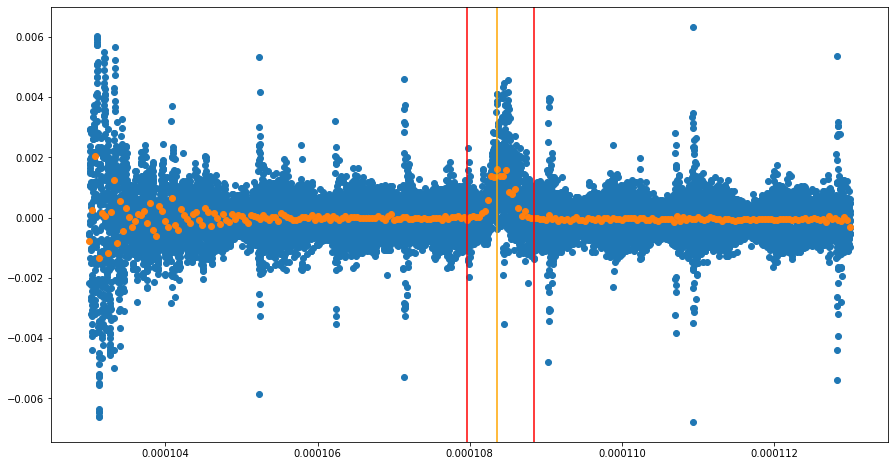

In [74]:
plot_MCP5n('/eos/experiment/gbar/pgunpc/data/24_05_24/WF1234.1716515579.980.trc')

NE50 line intensity: 11.244000
[[0.00010792001257512105, 0.00010884001258740437], [6150, 7300]]


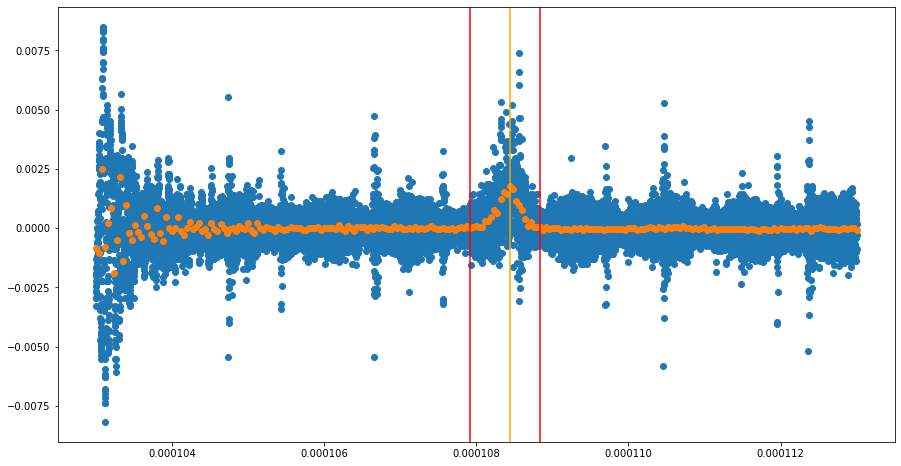

In [78]:
list(df[df.LyA == '/eos/experiment/gbar/pgunpc/data/24_05_24/24_05_24lya/LY1234.1716524680.690.trc']['Waveform_12bit'])
plot_MCP5n('/eos/experiment/gbar/pgunpc/data/24_05_24/WF1234.1716524680.690.trc')

NE50 line intensity: 9.167000
[[0.00010776064055531177, 0.00010888064057026537], [5950, 7350]]


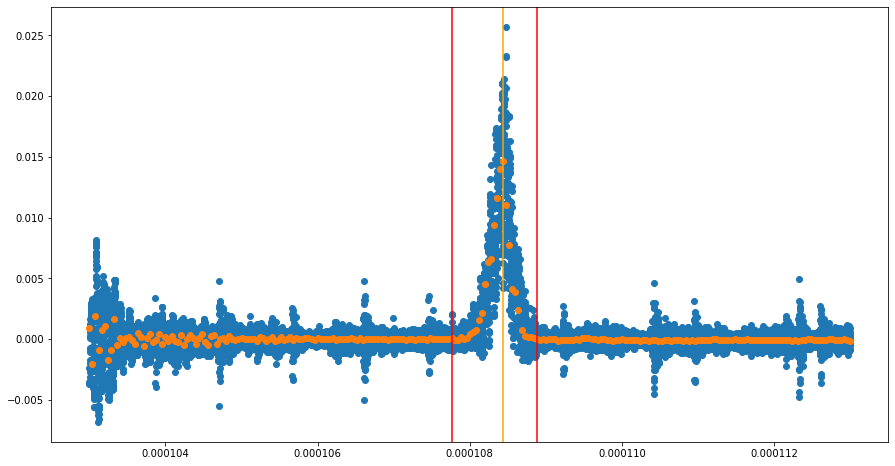

In [83]:
plot_MCP5n('/eos/experiment/gbar/pgunpc/data/24_05_16/WF1234.1715882866.775.trc')

/eos/experiment/gbar/pgunpc/data/24_04_30/WF1234.1714467211.838.trc


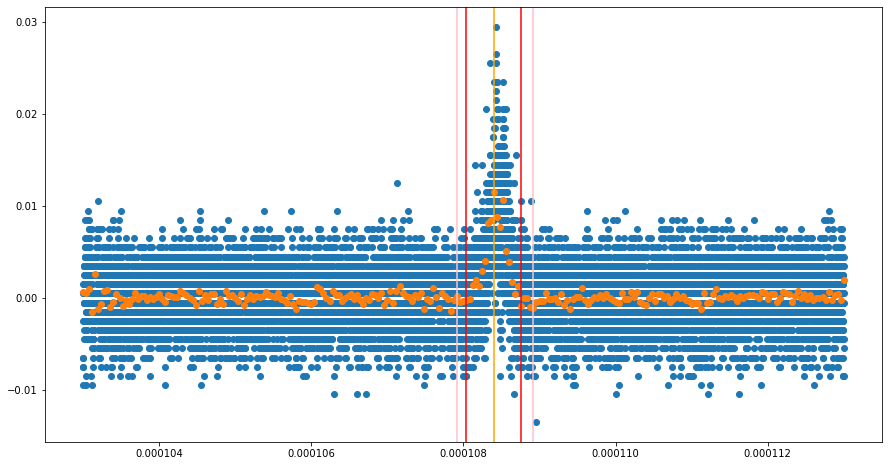

In [46]:
plot_MCP5n('/eos/experiment/gbar/pgunpc/data/24_04_30/WF1234.1714467211.838.trc')

[[0.0001076406346626934, 0.00010876063467764701], [5800, 7200]]


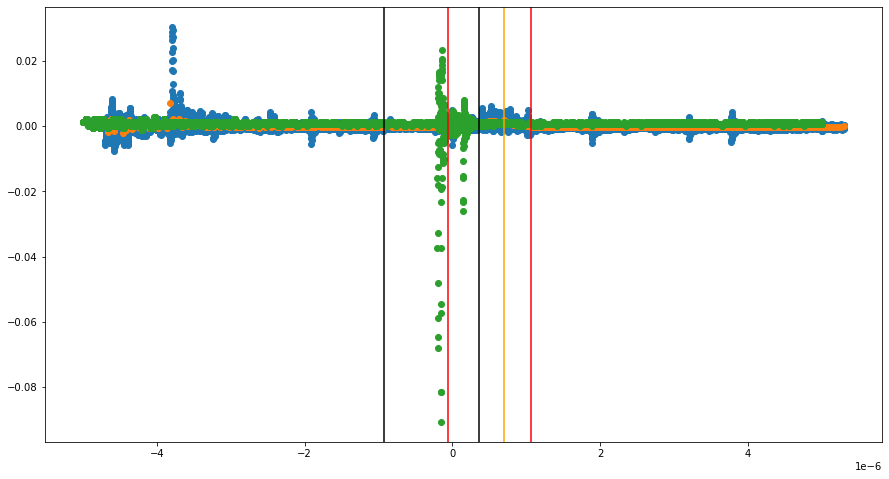

In [82]:
plot_MCP5_LyA('/eos/experiment/gbar/pgunpc/data/24_05_17/WF1234.1715913339.915.trc','/eos/experiment/gbar/pgunpc/data/24_05_17/24_05_17lya/LY1234.1715913340.055.trc', ch = 3)

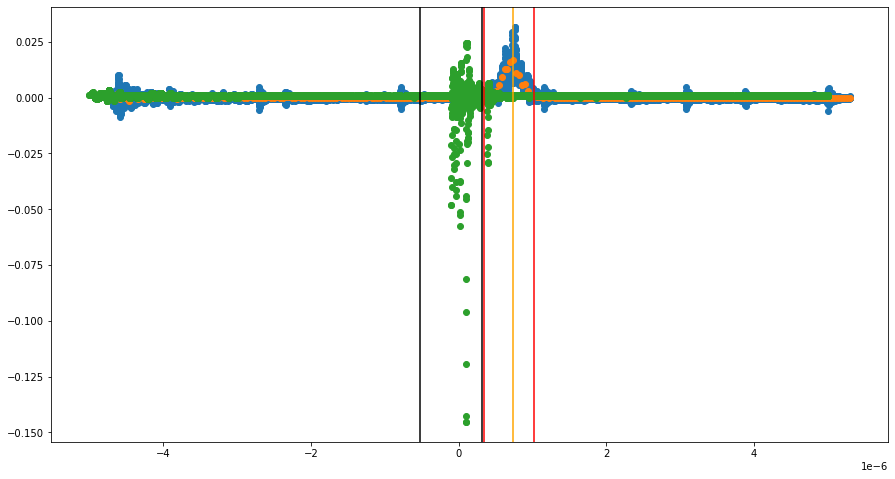

In [19]:
plot_MCP5_LyA('/eos/experiment/gbar/pgunpc/data/24_05_16/WF1234.1715883038.960.trc', '/eos/experiment/gbar/pgunpc/data/24_05_16/24_05_16lya/LY1234.1715883039.973.trc', ch = 3)

In [84]:
date = '24_04_30'
sm = pd.read_csv('/eos/user/l/lkoller/GBAR/data24/datasummary24/24_04_30/shortSum_24_04_30.txt', delimiter = '\t')
#sm = pd.concat([sm[sm['run number'] == 411], sm[sm['run number'] == 412]]).reset_index(drop = True)
data = Ldate(date).read()
data = data[[val == 411 or val == 412 for val in data['run number']]]

In [85]:
flist = [val for val in sm['Waveform_12bit'] if str(val) != 'nan']

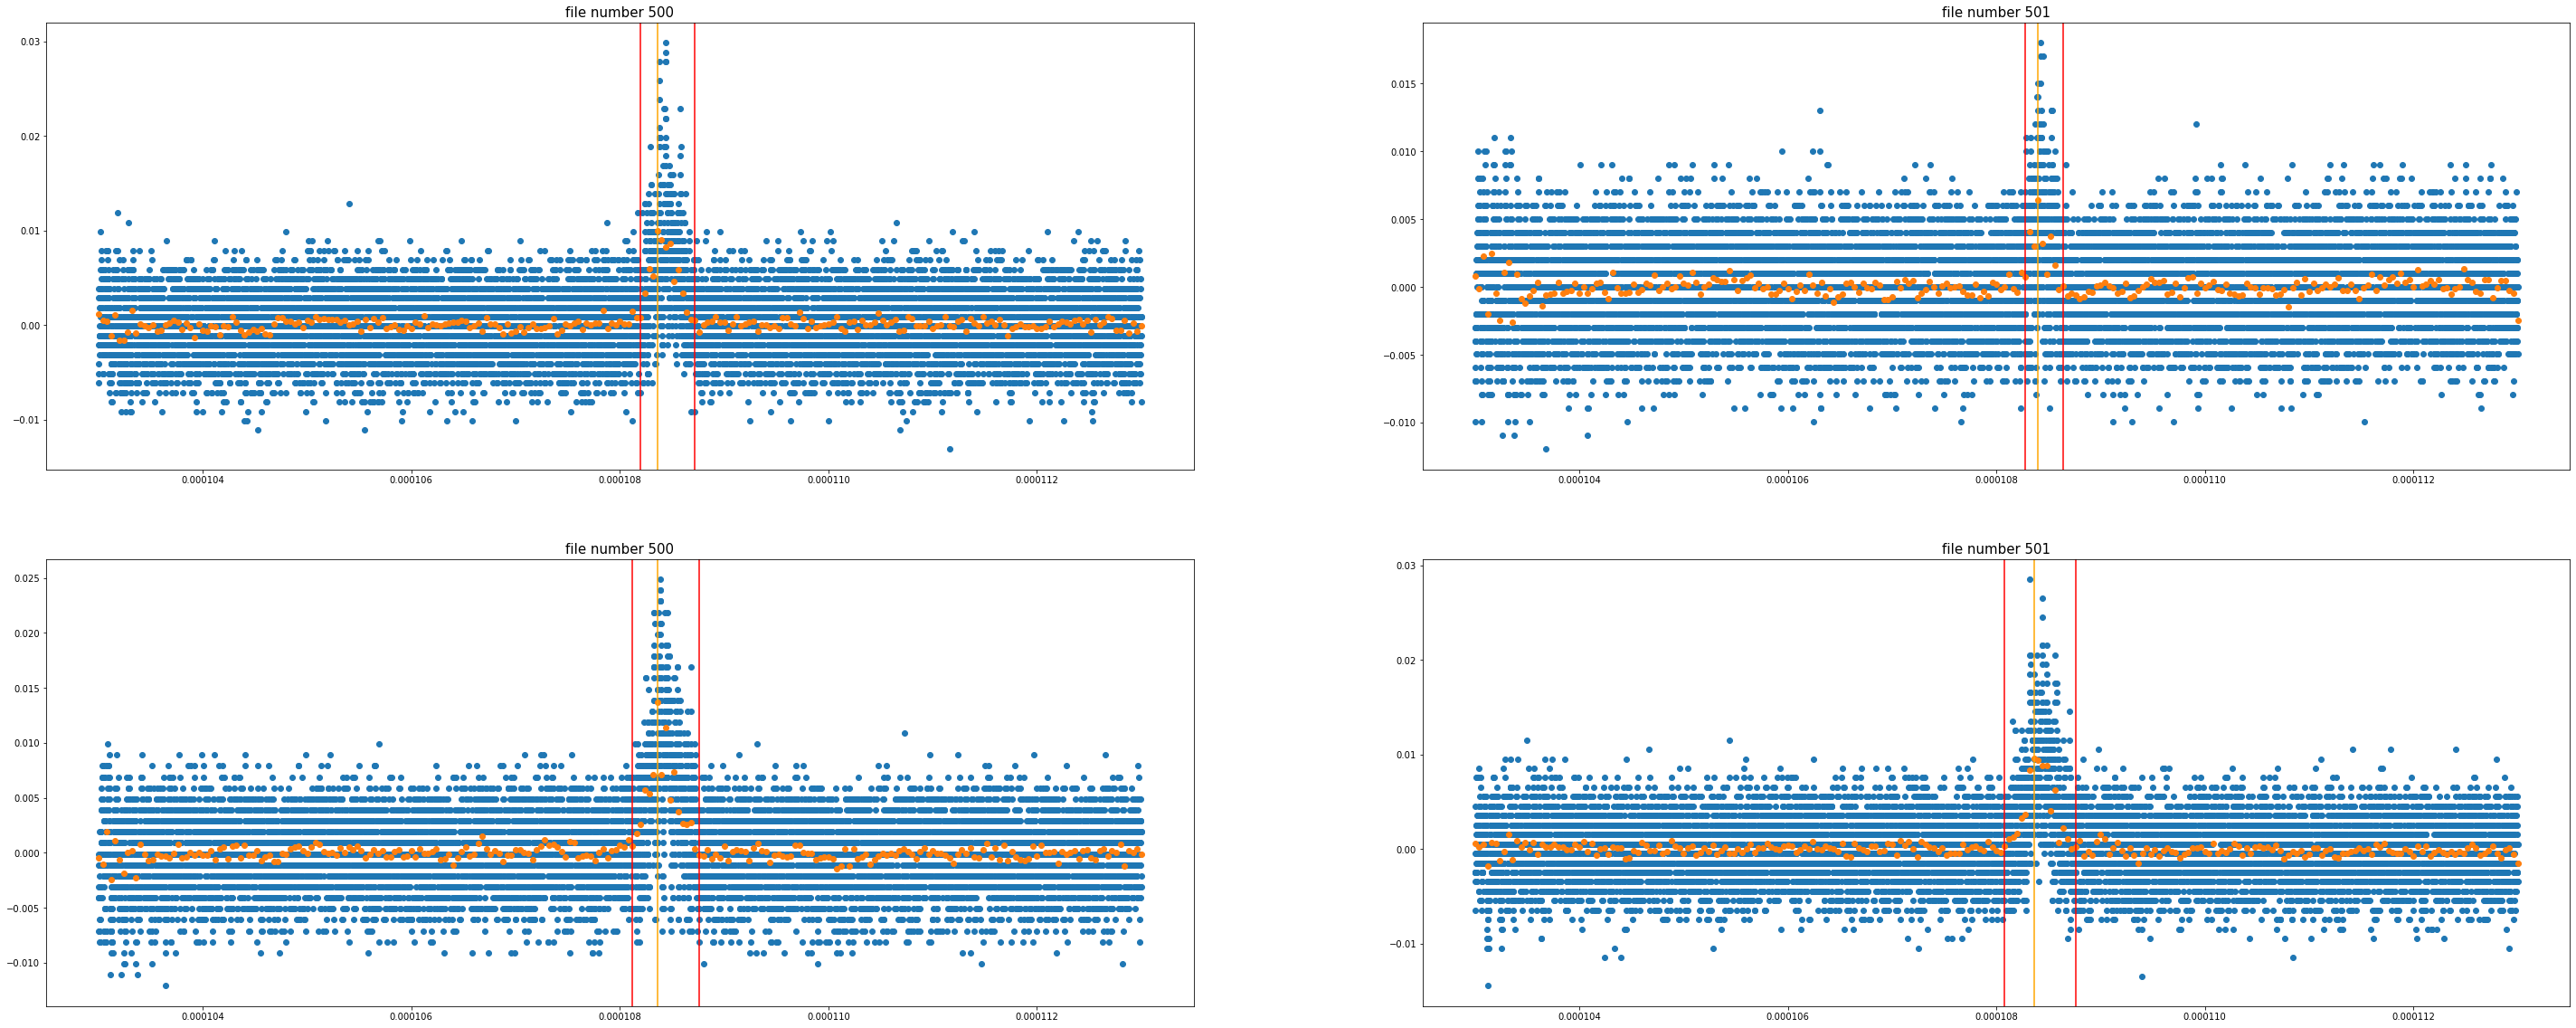

In [69]:
plot_MCP5n(flist[:4])

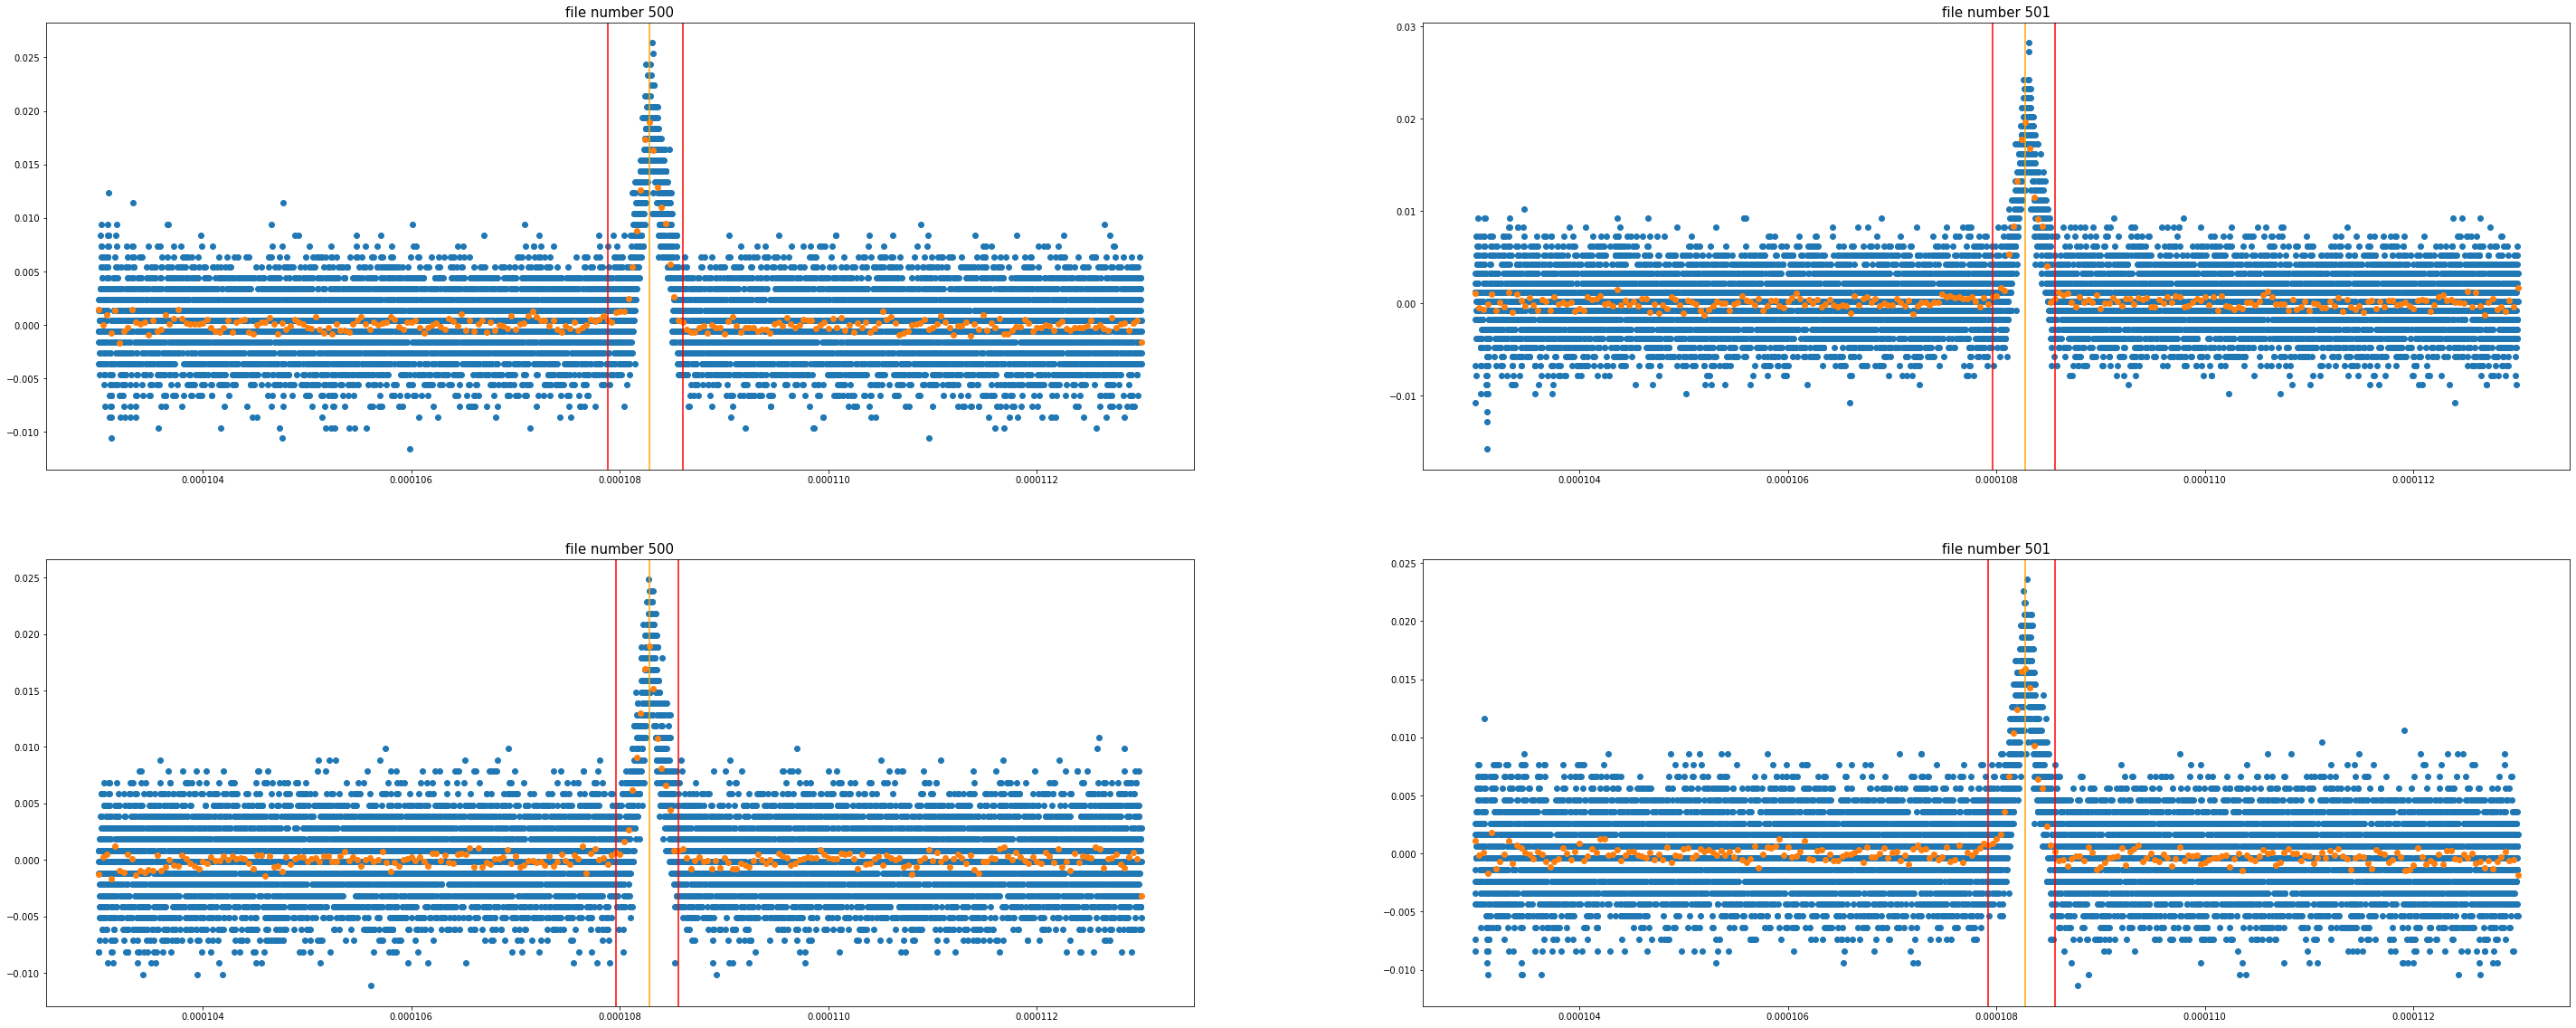

In [62]:
plot_MCP5n(flist[10:14])

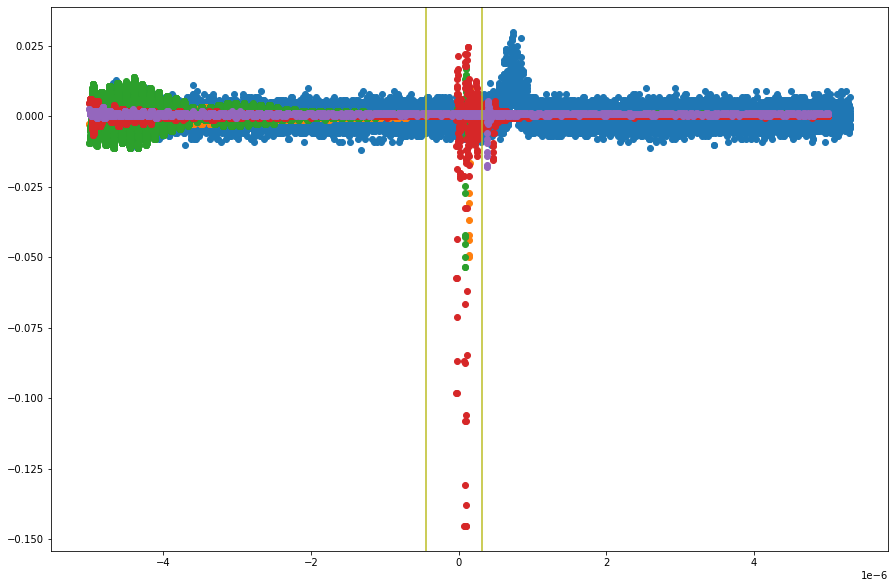

In [47]:
loc = [6]

for i in loc:
    plt.figure(figsize = (15,10))
    
    file = data['filepath'].iloc[i]
    wf = list(sm[sm['LyA'] == file]['Waveform_12bit'])[0]
    
    pd = list(sm[sm['LyA'] == file]['PCOs delay'])[0]
    ld = list(sm[sm['LyA'] == file]['LyA delay'])[0]
    md = list(sm[sm['LyA'] == file]['Main delay'])[0]

    window,_ = Lya_window(wf)
    
    wfdat = read(wf)
    st = wfdat[0][2][0]
    delay = st - 0.0000003 + 0.000005
    #x = [val - st - 0.000005 for val in wfdat[0][2]]
    x = [val - delay for val in wfdat[0][2]]
    y = wfdat[1][2]
    av = sum(y[1000:5000])/4000
    y = [val - av for val in y]
    plt.scatter(x,y)

    filedat = read(file)
    plt.scatter(filedat[0][0], filedat[1][0])
    plt.scatter(filedat[0][0], filedat[1][1])
    plt.scatter(filedat[0][0], filedat[1][2])
    plt.scatter(filedat[0][0], filedat[1][3])

    plt.axvline(window[0] - delay - 0.00000086, color = 'tab:olive')
    plt.axvline(window[1] - delay - 0.00000070, color = 'tab:olive')

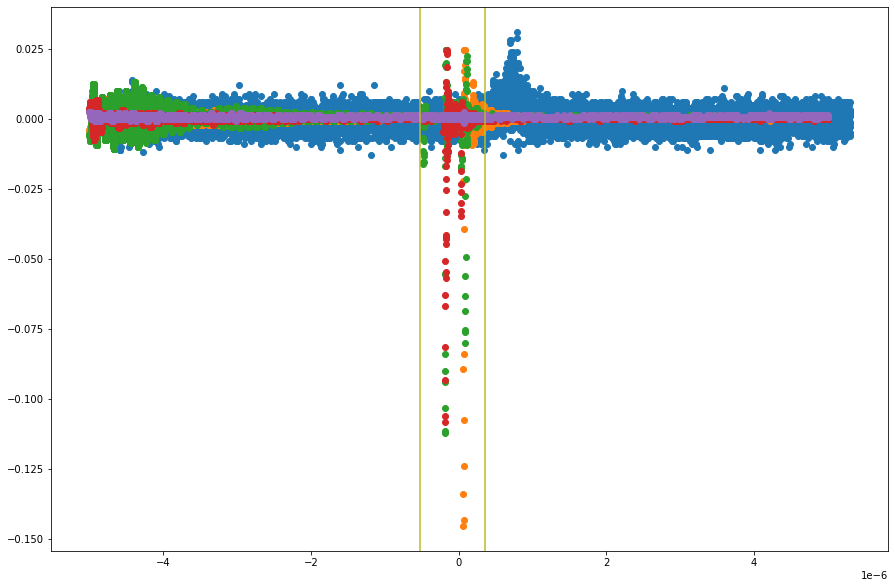

In [49]:
loc = [0]

for i in loc:
    plt.figure(figsize = (15,10))
    
    file = '/eos/experiment/gbar/pgunpc/data/24_04_30/24_04_30lya/LY1234.1714467282.854.trc'
    wf = list(sm[sm['LyA'] == file]['Waveform_12bit'])[0]
    
    pp = list(sm[sm['LyA'] == file]['PCOs delay'])[0]
    ld = list(sm[sm['LyA'] == file]['LyA delay'])[0]
    md = list(sm[sm['LyA'] == file]['Main delay'])[0]

    window,_ = Lya_window(wf)
    
    wfdat = read(wf)
    st = wfdat[0][2][0]
    delay = st - 0.0000003 + 0.000005
    #x = [val - st - 0.000005 for val in wfdat[0][2]]
    x = [val - delay for val in wfdat[0][2]]
    y = wfdat[1][2]
    av = sum(y[1000:5000])/4000
    y = [val - av for val in y]
    plt.scatter(x,y)

    filedat = read(file)
    plt.scatter(filedat[0][0], filedat[1][0])
    plt.scatter(filedat[0][0], filedat[1][1])
    plt.scatter(filedat[0][0], filedat[1][2])
    plt.scatter(filedat[0][0], filedat[1][3])

    plt.axvline(window[0] - delay - 0.00000086, color = 'tab:olive')
    plt.axvline(window[1] - delay - 0.00000070, color = 'tab:olive')

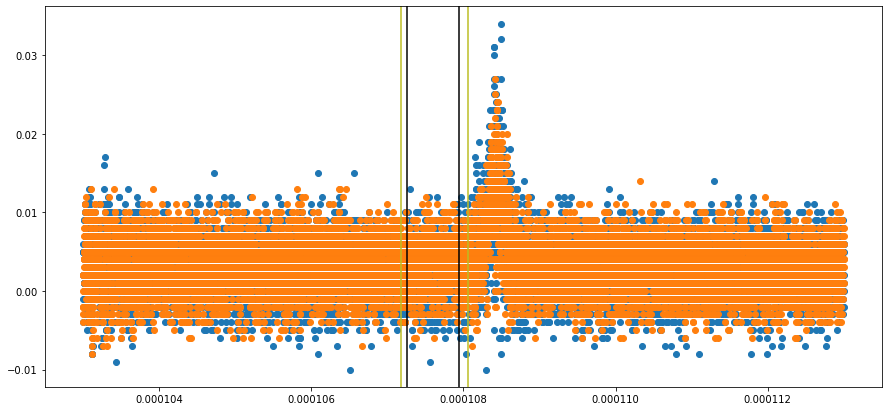

In [60]:
file1 = '/eos/experiment/gbar/pgunpc/data/24_04_30/24_04_30lya/LY1234.1714467282.854.trc'
file2 = '/eos/experiment/gbar/pgunpc/data/24_04_30/24_04_30lya/LY1234.1714466813.059.trc'

wf1 = list(sm[sm['LyA'] == file1]['Waveform_12bit'])[0]
wf2 = list(sm[sm['LyA'] == file2]['Waveform_12bit'])[0]

wfdat1 = read(wf1)
wfdat2 = read(wf2)

window1,_ = Lya_window(wf1)
window2,_ = Lya_window(wf2)

plt.figure(figsize = (15,7))

delay = 0
plt.axvline(window1[0] - delay - 0.00000086, color = 'tab:olive')
plt.axvline(window1[1] - delay - 0.00000070, color = 'tab:olive')
plt.axvline(window2[0] - delay - 0.00000086, color = 'black')
plt.axvline(window2[1] - delay - 0.00000070, color = 'black')

plt.scatter(wfdat1[0][2], wfdat1[1][2])
plt.scatter(wfdat2[0][2], wfdat2[1][2])